![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/16.Adverse_Drug_Event_ADE_NER_and_Classifier.ipynb)

# Adverse Drug Event (ADE) Pretrained NER and Classifier Models

`ADE NER`: Extracts ADE and DRUG entities from clinical texts.

`ADE Classifier`: CLassify if a sentence is ADE-related (`Negative`) or not (`Neutral`)

We use several datasets to train these models:

- Twitter dataset, which is used in paper "`Deep learning for pharmacovigilance: recurrent neural network architectures for labeling adverse drug reactions in Twitter posts`" (https://pubmed.ncbi.nlm.nih.gov/28339747/)
- ADE-Corpus-V2, which is used in paper "`An Attentive Sequence Model for Adverse Drug Event Extraction from Biomedical Text`" (https://arxiv.org/abs/1801.00625) and availe online: https://sites.google.com/site/adecorpus/home/document.

In [1]:
import json

with open('workshop_license_keys_365.json') as f:
    license_keys = json.load(f)

license_keys.keys()


dict_keys(['PUBLIC_VERSION', 'JSL_VERSION', 'SECRET', 'SPARK_NLP_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET'])

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
version = license_keys['PUBLIC_VERSION']
jsl_version = license_keys['JSL_VERSION']

! pip install --ignore-installed -q pyspark==2.4.4

! python -m pip install --upgrade spark-nlp-jsl==$jsl_version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

! pip install --ignore-installed -q spark-nlp==$version

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

import sparknlp
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

## ADE Classifier Pipeline (with a pretrained model)

`Negative` : The sentence is talking about a possible ADE

`Neutral` : The sentences has information about any ADE.

Here are the test set metrics

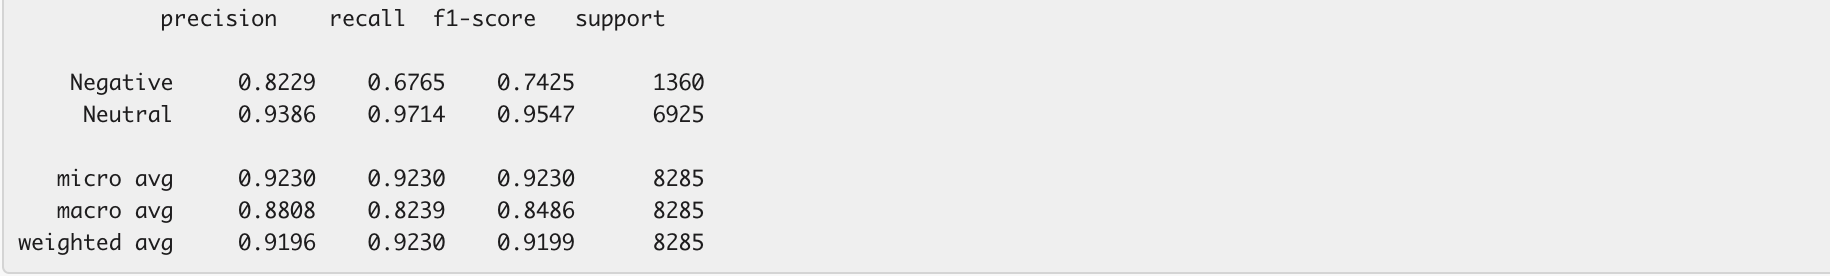

In [9]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained("biobert_pubmed_base_cased", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")
  
embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["sentence", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")\
      .setStorageRef('biobert_pubmed_base_cased')

classsifierdl = ClassifierDLModel.pretrained("classifierdl_ade_biobert", "en", "clinical/models")\
      .setInputCols(["sentence", "sentence_embeddings"]) \
      .setOutputCol("class")

ade_clf_pipeline = Pipeline(
    stages=[documentAssembler, 
            tokenizer,
            bert_embeddings,
            embeddingsSentence,
            classsifierdl])


empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_clf_model = ade_clf_pipeline.fit(empty_data)

ade_lp_pipeline = LightPipeline(ade_clf_model)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 383.1 MB
[OK!]
classifierdl_ade_biobert download started this may take some time.
Approximate size to download 21.6 MB
[OK!]


In [ ]:
text = "I feel a bit drowsy & have a little blurred vision, so far no gastric problems."

ade_lp_pipeline.annotate(text)['class'][0]

'Negative'

In [ ]:
text="I just took an Advil and have no gastric problems so far."

ade_clf_model.annotate(text)['class'][0]

'Neutral'

as you see `gastric problems` is not detected as `ADE` as it is in a negative context. So, classifier did a good job detecting that.

In [ ]:
text="I just took an metformin and and started to feel dizzy."

ade_lp_pipeline.annotate(text)['class'][0]

'Negative'

In [ ]:
texts = ["I feel a bit drowsy & have a little blurred vision, so far no gastric problems.",
"I've been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it.",
"Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes.",
"So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50."]

for text in texts:

  result = ade_lp_pipeline.annotate(text)

  print (result['class'][0])


Negative
Neutral
Negative
Neutral


## ADE NER

Extracts `ADE` and `DRUG` entities from text.

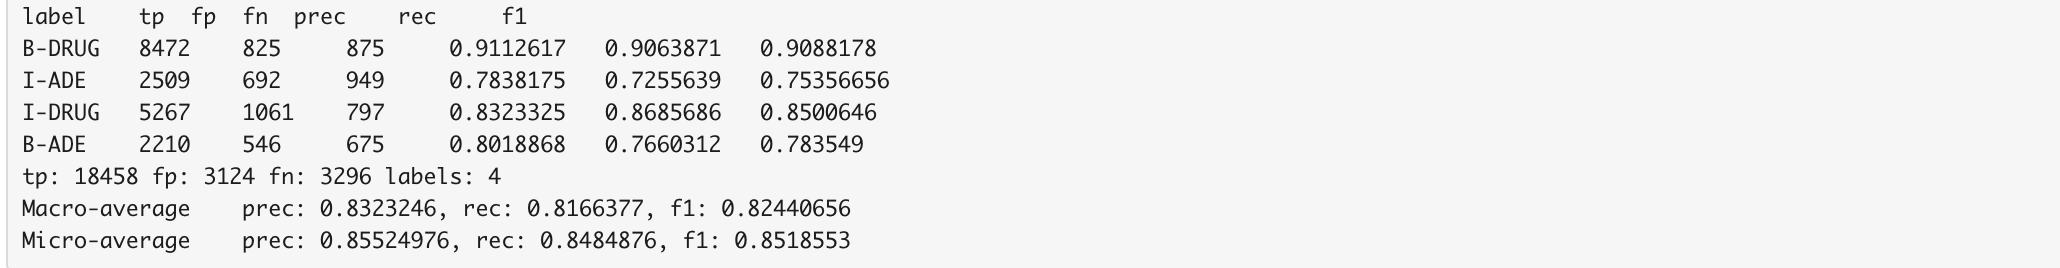

In [ ]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

ade_ner = NerDLModel.pretrained("ner_ade_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

ade_ner_lp = LightPipeline(ade_ner_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_ade_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
light_result = ade_ner_lp.fullAnnotate("I feel a bit drowsy & have a little blurred vision, so far no gastric problems. I have been on Arthrotec 50 for over 10 years on and off, only taking it when I needed it. Due to my arthritis getting progressively worse, to the point where I am in tears with the agony, gp's started me on 75 twice a day and I have to take it every day for the next month to see how I get on, here goes. So far its been very good, pains almost gone, but I feel a bit weird, didn't have that when on 50.")

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end})

df

,chunks,entities,begin,end
0,bit drowsy,ADE,9,18
1,little blurred vision,ADE,29,49
2,Arthrotec,DRUG,95,103


as you see `gastric problems` is not detected as `ADE` as it is in a negative context. So, NER did a good job ignoring that.

#### ADE NER with 100d embeddings (lighter version with almost the same accuracy)

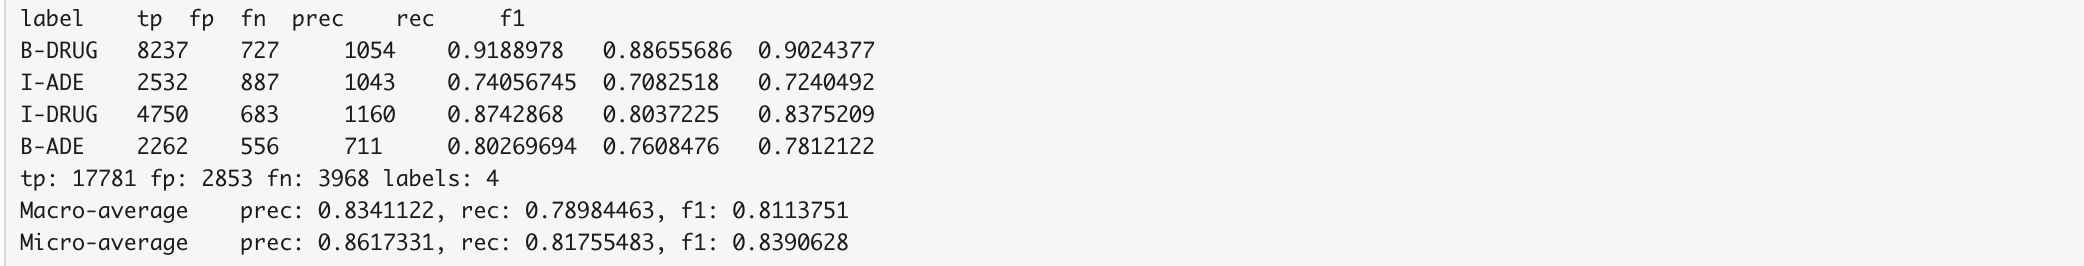

In [3]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_healthcare_100d", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

ade_ner_100d = NerDLModel.pretrained("ner_ade_healthcare", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner_100d,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

ade_ner_lp = LightPipeline(ade_ner_model)

embeddings_healthcare_100d download started this may take some time.
Approximate size to download 475.8 MB
[OK!]
ner_ade_healthcare download started this may take some time.
Approximate size to download 13.5 MB
[OK!]


In [8]:
light_result = ade_ner_lp.fullAnnotate("As she became very drowsy, we discontinued Dilantin discharge medication")

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 

import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                    'begin': begin, 'end': end})

df

,chunks,entities,begin,end
0,drowsy,ADE,19,24
1,Dilantin discharge medication,DRUG,43,71


## ADE models applied to Spark Dataframes

In [10]:
! wget -q	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed-sample.csv

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("./pubmed-sample.csv")\
                .filter("AB IS NOT null")\
                .withColumnRenamed("AB", "text")\
                .drop("TI")

pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"Monomeric sarcosine oxidase (MSOX) is a flavoe...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [ ]:
import pyspark.sql.functions as F

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['ADE'])

ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ade_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_ner_model = ner_pipeline.fit(empty_data)

result = ade_ner_model.transform(pubMedDF)

result.select('text','ner_chunk.result')\
.toDF('text','ADE_phrases').filter(F.size('ADE_phrases')>1)\
.show(truncate=70)


+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                  text|                                                           ADE_phrases|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|Kohlschutter syndrome is a rare neurodegenerative disorder presenti...|[seizures, developmental regression and characteristic hypoplasticd...|
|We conducted a phase II study to assess the efficacy and tolerabili...|[metastatic gastric cancer,progressive, nausea, metastatic gastricc...|
|OBJECTIVE: To evaluate the effectiveness and acceptability of expec...|[trimester incomplete abortion.METHODS, feeling anxious, increase a...|
|Intraparenchymal pericatheter cyst is rarely reported. Obstruction ...|                             [local mass effect, neurological de

#### creating sentence dataframe (one sentence per row) and getting ADE entities and categories

In [11]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")\
  .setExplodeSentences(True)

sent_splitter_model = PipelineModel(stages=[
    documentAssembler, 
    sentenceDetector])

pubmed_Sentences = sent_splitter_model.transform(pubMedDF)

In [14]:
documentAssembler.transform(pubMedDF).select('document.result').show()

+--------------------+
|              result|
+--------------------+
|[The human KCNJ9 ...|
|[BACKGROUND: At p...|
|[OBJECTIVE: To in...|
|[Combined EEG/fMR...|
|[Kohlschutter syn...|
|[Statistical anal...|
|[The synthetic DO...|
|[Our objective wa...|
|[We conducted a p...|
|["Monomeric sarco...|
|[We presented the...|
|[The literature d...|
|[A novel approach...|
|[An HPLC-ESI-MS-M...|
|[The localizing a...|
|[OBJECTIVE: To ev...|
|[For the construc...|
|[We report the re...|
|[Intraparenchymal...|
|[It is known that...|
+--------------------+
only showing top 20 rows



In [ ]:
sentence_Df = pubmed_Sentences.select(F.explode('sentence.result').alias('text'))

sentence_Df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activated inwardly rectifying potas...|
|Here we describe the genomicorganization of the KCNJ9 locus on chromosome 1q21-23 as a candidate ...|
|The gene spansapproximately 7.6 kb and contains one noncoding and two coding exons separated byap...|
|We identified14 single nucleotide polymorphisms (SNPs), including one that predicts aVal366Ala su...|
|                                                                            (bp) insertion/deletion.|
|Ourexpression studies revealed the presence of the transcript in various humantissues including p...|
|The characterization of the KCNJ9 gene should facilitate furtherstudies 

In [ ]:
result = ade_ner_model.transform(sentence_Df)

result.select('text','ner_chunk.result')\
.toDF('text','ADE_phrases').filter(F.size('ADE_phrases')>1)\
.show(truncate=70)

+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                  text|                                                           ADE_phrases|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|Kohlschutter syndrome is a rare neurodegenerative disorder presenti...|[seizures, developmental regression and characteristic hypoplasticd...|
|We report two cases of distal catheter obstruction withformation of...|                             [local mass effect, neurological deficit]|
|A low-calcium diet reduced and rhGH increased basal lengthgain and ...|                             [increased basal lengthgain, weight gain]|
|Total body calcium corrected for body weight decreased with a low-c...|                           [Total body calcium, body weight decr

In [ ]:
ade_result = ade_clf_model.transform(sentence_Df).select('text',F.explode('class.result').alias('is_ADE'))

ade_result.show(truncate=70)

+----------------------------------------------------------------------+-------+
|                                                                  text| is_ADE|
+----------------------------------------------------------------------+-------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activ...|Neutral|
|Here we describe the genomicorganization of the KCNJ9 locus on chro...|Neutral|
|The gene spansapproximately 7.6 kb and contains one noncoding and t...|Neutral|
|We identified14 single nucleotide polymorphisms (SNPs), including o...|Neutral|
|                                              (bp) insertion/deletion.|Neutral|
|Ourexpression studies revealed the presence of the transcript in va...|Neutral|
|The characterization of the KCNJ9 gene should facilitate furtherstu...|Neutral|
|BACKGROUND: At present, it is one of the most important issues for ...|Neutral|
|With the objective of determining the usefulnessof vinorelbine mono...|Neutral|
|METHODS: Vinorelbinewas adm